In [1]:
%xmode Plain


Exception reporting mode: Plain


In [2]:
import os
os.environ["IPYTHON_DISABLE_PROMPT_TOOLKIT"] = "1"  # optionnel


# RSA-128 — Bande conditionnelle u(pmin) | u(n) (échelle 128)

Ce notebook part d’un corpus **RSA‑128** (n = p·q avec p,q ~ 64 bits), construit une **bande conditionnelle** pour le plus petit facteur premier  
\(u(p_{min}) \mid u(n)\) via des quantiles **Q5–Q95**, puis illustre :

- la **réduction** de l’intervalle candidat de p,
- la **couverture** (probabilité que p soit dans la bande),
- et la démonstration « on sort p, puis on déduit q = n/p ».

> Convention de noms (pour éviter toute confusion)  
> **df128** : dataset semiprimes (50k lignes)  
> **band_df** : table de bande (NBINS lignes)  


In [3]:
from pathlib import Path
import gmpy2
import numpy as np
import pandas as pd
import math, csv, secrets, time, random


## 1) Chargement du corpus RSA-128 (case_128)

Le fichier CSV attendu contient (au minimum) :  
- `n_hex, p_hex, q_hex`  
- `u_n, theta_n`  
- `pmin_hex, u_pmin` (optionnel mais pratique)

Si besoin, adapte `DATA_CSV`.


In [4]:
DATA_CSV = Path.cwd() / "case_128" / "semiprimes_128_50000_p64_q64.csv"
assert DATA_CSV.exists(), f"CSV introuvable: {DATA_CSV}"

df128 = pd.read_csv(DATA_CSV)
print("Loaded:", DATA_CSV)
print("Rows:", len(df128))
print("Columns:", list(df128.columns))


Loaded: C:\Users\danie\Notebook\Etudes finalisées\case_128\semiprimes_128_50000_p64_q64.csv
Rows: 50000
Columns: ['n_hex', 'p_hex', 'q_hex', 'bits_n', 'bits_p', 'bits_q', 'u_n', 'theta_n', 'pmin_hex', 'qmax_hex', 'u_pmin', 'u_qmax']


In [5]:
def build_s0_edges_by_bin(df128, band_df_1d, B=128, K=4, min_bin_support=80):
    """Quantification adaptative de uhat0 (= centre de bande 1D) conditionnellement au bin j.

    Retourne une liste edges_by_j de longueur B:
      - edges_by_j[j] = array(K+1) de seuils croissants (quantiles)
      - ou None si support insuffisant / distribution dégénérée
    """
    u = df128["u_n"].to_numpy(float)
    j = np.floor(B * u).astype(int)
    j = np.clip(j, 0, B-1)

    lo1 = band_df_1d["u_pmin_lo"].to_numpy(float)[j]
    hi1 = band_df_1d["u_pmin_hi"].to_numpy(float)[j]
    uhat0 = 0.5 * (lo1 + hi1)

    qs = np.linspace(0.0, 1.0, K+1)
    edges_by_j = [None] * B

    for jj in range(B):
        vals = uhat0[j == jj]
        if vals.size < min_bin_support:
            continue
        e = np.quantile(vals, qs)
        e = np.maximum.accumulate(e)  # monotone
        if np.allclose(e, e[0]):
            continue
        edges_by_j[jj] = e

    return edges_by_j


In [6]:
def build_auto2d_adaptive(df128, band_df_1d, edges_by_j, B=128, K=4, q_lo=0.05, q_hi=0.95, min_support=20):
    """Apprend la table (bin=j, s0)->[u_lo,u_hi] avec s0 obtenu par quantiles adaptatifs de uhat0, bin-par-bin.

    Colonnes attendues dans df128: u_n, u_pmin (float).
    band_df_1d: colonnes u_pmin_lo, u_pmin_hi, et u_n_center pour infer_1d.
    edges_by_j: liste longueur B d'edges quantiles (K+1) ou None.
    """
    u = df128["u_n"].to_numpy(float)
    up = df128["u_pmin"].to_numpy(float)

    j = np.floor(B * u).astype(int)
    j = np.clip(j, 0, B-1)

    lo1 = band_df_1d["u_pmin_lo"].to_numpy(float)[j]
    hi1 = band_df_1d["u_pmin_hi"].to_numpy(float)[j]
    uhat0 = 0.5 * (lo1 + hi1)

    # s0 adaptatif (quantiles par bin)
    s0 = np.zeros_like(j)
    for jj in range(B):
        e = edges_by_j[jj]
        m = (j == jj)
        if not np.any(m):
            continue
        if e is None:
            s0[m] = 0
        else:
            s0[m] = np.searchsorted(e[1:-1], uhat0[m], side="right")

    rows = []
    for jj in range(B):
        for ss in range(K):
            m = (j == jj) & (s0 == ss)
            support = int(m.sum())
            if support >= min_support:
                u_lo = float(np.quantile(up[m], q_lo))
                u_hi = float(np.quantile(up[m], q_hi))
            else:
                u_lo = np.nan
                u_hi = np.nan
            rows.append((jj, ss, u_lo, u_hi, support))

    return pd.DataFrame(rows, columns=["bin", "s0", "u_lo", "u_hi", "support"])


## 2) Utilitaires dyadiques

- \(u(x)\) : position relative de x dans son palier dyadique \([2^{k-1}, 2^k)\)  
- \(\theta(x) = 2\pi\, \mathrm{frac}(\log_2 x)\) : phase log-dyadique (utile pour l’étape 2D plus tard)


In [7]:
def u_in_pallier(x: int) -> float:
    k = int(x).bit_length()
    low = 1 << (k - 1)
    return (int(x) - low) / low

def theta_log(x: int) -> float:
    k = int(x).bit_length()
    low = 1 << (k - 1)
    mant = int(x) / low
    frac = math.log(mant, 2.0)  # in [0,1)
    return 2.0 * math.pi * frac

def hex_to_int(s):
    if isinstance(s, str):
        s = s.strip()
        if s.startswith(("0x","0X")):
            return int(s, 16)
        return int(s)
    return int(s)

def infer_1d(u_n, band_df, B=128):
    j = min(int(B*u_n), B-1)
    row = band_df.iloc[j]
    return float(row["u_pmin_lo"]), float(row["u_pmin_hi"]), j

def build_auto2d(df, band_df_1d, B=128, K=8, q_lo=0.10, q_hi=0.90, min_support=20):
    u = df["u_n"].to_numpy()
    up = df["u_pmin"].to_numpy()

    j = np.clip((B*u).astype(int), 0, B-1)

    # 1D -> u_hat0
    lo1 = band_df_1d["u_pmin_lo"].to_numpy()[j]
    hi1 = band_df_1d["u_pmin_hi"].to_numpy()[j]
    uhat0 = 0.5*(lo1 + hi1)

    s0 = np.clip((K*uhat0).astype(int), 0, K-1)

    rows=[]
    for jj in range(B):
        for ss in range(K):
            m = (j==jj) & (s0==ss)
            support = int(m.sum())
            if support >= min_support:
                lo = float(np.quantile(up[m], q_lo))
                hi = float(np.quantile(up[m], q_hi))
            else:
                lo = hi = np.nan
            rows.append((jj, ss, lo, hi, support))

    return pd.DataFrame(rows, columns=["bin","s0","u_lo","u_hi","support"])


In [8]:
def measure_policy(samples, infer_u_band, progress_every=500):
    full_lo = 1<<63
    full_hi = (1<<64)-1
    full_width = full_hi - full_lo

    cov=0
    widths=[]
    hits_widths=[]
    used_auto=0

    t0=time.time()
    for i,(n,p,q) in enumerate(samples, start=1):
        pmin = p if p<q else q
        u_n = u_in_pallier(n)

        u_lo,u_hi,tag = infer_u_band(u_n)
        if tag=="auto2d": used_auto += 1

        p_lo,p_hi = u_interval_to_int_interval(u_lo,u_hi,64)
        w = max(1, p_hi - p_lo)
        widths.append(w)

        hit = (p_lo <= pmin <= p_hi)
        cov += int(hit)
        if hit: hits_widths.append(w)

        if i==1 or i%progress_every==0:
            print(f"{i}/{len(samples)} cov={cov/i:.3f} mean_w={np.mean(widths)/full_width:.3f} auto={used_auto/i:.3f}", flush=True)

    widths=np.array(widths)
    hits_widths=np.array(hits_widths) if hits_widths else np.array([np.nan])

    return {
        "M": len(samples),
        "coverage": cov/len(samples),
        "mean_width_frac": float(widths.mean()/full_width),
        "p95_width_frac": float(np.quantile(widths,0.95)/full_width),
        "mean_width_hit_frac": float(np.nanmean(hits_widths)/full_width),
        "rate_auto2d": used_auto/len(samples)
    }


In [9]:
def make_auto2d_lookup_adaptive(auto2d_df, band_df_1d, edges_by_j, B=128, K=4, min_support=20):
    """Retourne une fonction infer(u_n)->(u_lo,u_hi,tag) avec accept-if-better vs bande 1D."""
    d = {}
    for _, r in auto2d_df.iterrows():
        if r["support"] >= min_support and np.isfinite(r["u_lo"]) and np.isfinite(r["u_hi"]):
            d[(int(r["bin"]), int(r["s0"]))] = (float(r["u_lo"]), float(r["u_hi"]))

    def infer(u_n):
        u_lo0, u_hi0, j = infer_1d(u_n, band_df_1d, B=B)
        uhat0 = 0.5 * (u_lo0 + u_hi0)

        e = edges_by_j[j]
        s0 = 0 if e is None else int(np.searchsorted(e[1:-1], uhat0, side="right"))

        got = d.get((j, s0))
        if got is None:
            return u_lo0, u_hi0, "1d"

        u_lo1, u_hi1 = got

        # accept-if-better
        if (u_hi1 - u_lo1) < (u_hi0 - u_lo0):
            return u_lo1, u_hi1, "auto2d"
        else:
            return u_lo0, u_hi0, "1d"
    return infer


def make_auto2d_lookup_adaptive_DEBUG(auto2d_df, band_df_1d, edges_by_j, B=128, K=4, min_support=20):
    """Comme make_auto2d_lookup_adaptive, mais expose des stats: calls/got/accepted."""
    d = {}
    for _, r in auto2d_df.iterrows():
        if r["support"] >= min_support and np.isfinite(r["u_lo"]) and np.isfinite(r["u_hi"]):
            d[(int(r["bin"]), int(r["s0"]))] = (float(r["u_lo"]), float(r["u_hi"]))

    stats = {"calls": 0, "got": 0, "accepted": 0}

    def infer(u_n):
        stats["calls"] += 1

        u_lo0, u_hi0, j = infer_1d(u_n, band_df_1d, B=B)
        uhat0 = 0.5 * (u_lo0 + u_hi0)

        e = edges_by_j[j]
        s0 = 0 if e is None else int(np.searchsorted(e[1:-1], uhat0, side="right"))

        got = d.get((j, s0))
        if got is None:
            return u_lo0, u_hi0, "1d(no2d)"

        stats["got"] += 1
        u_lo1, u_hi1 = got

        if (u_hi1 - u_lo1) < (u_hi0 - u_lo0):
            stats["accepted"] += 1
            return u_lo1, u_hi1, "auto2d"
        else:
            return u_lo0, u_hi0, "1d(reject)"

    infer.stats = stats
    return infer


## 4) Raffinement adaptatif (auto‑2D) — construction & benchmark (à exécuter après `band_df` et `samples`)

## 3) Construction de la bande 1D : u(pmin) | u(n)

On binning u(n) en **NBINS** cases et on prend les quantiles **Q_LO–Q_HI** de u(pmin).


In [10]:
# ---- bande 1D params ----
NBINS = 128
Q_LO, Q_HI = 0.05, 0.95
MIN_SUPPORT = 30

# sécurité types
df128["u_n"] = df128["u_n"].astype(float)
df128["u_pmin"] = df128["u_pmin"].astype(float)

edges = np.linspace(0.0, 1.0, NBINS + 1)
centers = 0.5 * (edges[:-1] + edges[1:])

u  = df128["u_n"].to_numpy(float)
up = df128["u_pmin"].to_numpy(float)

bin_id = np.clip(np.digitize(u, edges) - 1, 0, NBINS - 1)

rows = []
for j in range(NBINS):
    mask = (bin_id == j)
    supp = int(mask.sum())
    if supp < MIN_SUPPORT:
        rows.append((centers[j], np.nan, np.nan, supp, np.nan, np.nan))
        continue
    vals = up[mask]
    lo = float(np.quantile(vals, Q_LO))
    hi = float(np.quantile(vals, Q_HI))
    width = max(0.0, hi - lo)
    reduction = 1.0 - width
    rows.append((centers[j], lo, hi, supp, width, reduction))

band_df = pd.DataFrame(rows, columns=["u_n_center","u_pmin_lo","u_pmin_hi","support","width","reduction"])

OUT_BAND = Path.cwd() / "case_128" / f"band_u_pmin_given_u_n_Q{int(Q_LO*100)}-{int(Q_HI*100)}_B{NBINS}_case128.csv"
band_df.to_csv(OUT_BAND, index=False)

print("Wrote band:", OUT_BAND)
print("band_df shape:", band_df.shape)
print("bins used:", int((band_df['support'] >= MIN_SUPPORT).sum()), "/", NBINS)
band_df.head()

Wrote band: C:\Users\danie\Notebook\Etudes finalisées\case_128\band_u_pmin_given_u_n_Q5-95_B128_case128.csv
band_df shape: (128, 6)
bins used: 128 / 128


,u_n_center,u_pmin_lo,u_pmin_hi,support,width,reduction
0,0.003906,0.015775,0.388360,549,0.372586,0.627414
1,0.011719,0.026783,0.394954,510,0.368171,0.631829
2,0.019531,0.036912,0.406626,498,0.369714,0.630286
3,0.027344,0.034537,0.406017,552,0.371480,0.628520
4,0.035156,0.044666,0.407306,533,0.362639,0.637361


## 4) Lookup bande + conversion en intervalle entier 64-bit

On prend le bin le plus proche de u(n), et on convertit u_lo/u_hi en un intervalle
\([p_{lo}, p_{hi}]\) dans \([2^{63}, 2^{64})\).


In [11]:
u_cent = band_df["u_n_center"].to_numpy(float)
u_lo_b = band_df["u_pmin_lo"].to_numpy(float)
u_hi_b = band_df["u_pmin_hi"].to_numpy(float)
supp_b = band_df["support"].to_numpy(int)

def band_lookup_u(u_n: float, min_support: int = MIN_SUPPORT):
    j = int(np.argmin(np.abs(u_cent - u_n)))
    lo, hi = u_lo_b[j], u_hi_b[j]
    if (supp_b[j] < min_support) or (not np.isfinite(lo)) or (not np.isfinite(hi)):
        return None, None, j
    return float(lo), float(hi), j

def u_interval_to_int_interval(u_lo: float, u_hi: float, bits: int = 64):
    # intervalle sur le palier [2^(bits-1), 2^bits)
    low = 1 << (bits - 1)
    high = (1 << bits) - 1
    a = int(low + u_lo * low)
    b = int(low + u_hi * low)
    a = max(low, min(a, high))
    b = max(low, min(b, high))
    if b < a:
        a, b = b, a
    # impairs (optionnel mais cohérent pour p premier)
    if a % 2 == 0: a += 1
    if b % 2 == 0: b -= 1
    return a, b

def infer_1d_only(u_n):
    u_lo, u_hi, _ = infer_1d(u_n, band_df, B=128)
    return u_lo, u_hi, "1d"

## 5) Coverage (vérification interne)

On vérifie que la bande apprise sur `df128` couvre bien ~ (Q_HI-Q_LO) des valeurs de u(pmin).
(ici on mesure la couverture *empirique* sur le même dataset, ce qui sert de sanity check).


In [12]:
# coverage sur le dataset d'apprentissage (sanity check)
cov = []
used = 0
for un, upmin in zip(df128["u_n"].to_numpy(float), df128["u_pmin"].to_numpy(float)):
    lo, hi, j = band_lookup_u(un)
    if lo is None:
        continue
    used += 1
    cov.append(int(lo <= upmin <= hi))

print("used bins:", used, "/", len(df128))
print("coverage (train-set):", float(np.mean(cov)) if cov else None)


used bins: 50000 / 50000
coverage (train-set): 0.89784


## 6) Démonstration : intervalle candidat pour pmin sur une instance

On peut choisir :
- soit une ligne aléatoire du corpus,
- soit un `n` généré à la volée (cf. cellule suivante).


In [13]:
# pick random row from df128 (reproductible)
row = df128.sample(1, random_state=7).iloc[0]
n = hex_to_int(row["n_hex"])
p = hex_to_int(row["pmin_hex"])  # on vise pmin
u_n = float(row["u_n"])
th_n = float(row["theta_n"])

u_lo, u_hi, j = band_lookup_u(u_n)
if u_lo is None:
    p_lo = 1 << 63
    p_hi = (1 << 64) - 1
    used_band = False
else:
    p_lo, p_hi = u_interval_to_int_interval(u_lo, u_hi, 64)
    used_band = True

full_lo = 1 << 63
full_hi = (1 << 64) - 1
full_width = full_hi - full_lo
band_width = max(1, p_hi - p_lo)
reduction = 1 - band_width / full_width

print("n bits:", n.bit_length())
print("u(n):", u_n, "theta(n):", th_n, "bin:", j)
print("true pmin:", hex(p))
print("band u(pmin):", (u_lo, u_hi))
print("p interval:", hex(p_lo), "…", hex(p_hi))
print("used band?:", used_band)
print("reduction (interval width):", reduction)
print("p in interval?:", p_lo <= p <= p_hi)


n bits: 128
u(n): 0.9337527987877544 theta(n): 5.977843736774485 bin: 119
true pmin: 0xfa88f0afa419188f
band u(pmin): (0.01360810161470612, 0.9494632147190188)
p interval: 0x81bde907b2a9d001 … 0xf98802b7fc922fff
used band?: True
reduction (interval width): 0.06414488689568731
p in interval?: False


## 7) Génération RSA-128 balanced (optionnel)

Permet de tester le filtre sur des instances générées à la volée.


In [14]:
# --- génération 64-bit prime (MR déterministe) + RSA-128 ---
# Objectif: générer des (p,q) ~ 64 bits rapidement et fiablement (pour measure_batch).
# NOTE: bases MR ci-dessous rendent le test déterministe pour n < 2**64.

def rand_odd_64() -> int:
    # 64-bit, MSB=1, odd
    x = secrets.randbits(64) | (1 << 63) | 1
    return x

def is_probable_prime_64(n: int) -> bool:
    if n < 2:
        return False
    # petits premiers pour éliminer vite
    small_primes = (2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37)
    for p in small_primes:
        if n == p:
            return True
        if n % p == 0:
            return False

    # Miller-Rabin: n-1 = d * 2^s avec d impair
    d = n - 1
    s = 0
    while (d & 1) == 0:
        s += 1
        d >>= 1

    def check(a: int) -> bool:
        a %= n
        if a == 0:
            return True
        x = pow(a, d, n)
        if x == 1 or x == n - 1:
            return True
        for _ in range(s - 1):
            x = (x * x) % n
            if x == n - 1:
                return True
        return False

    # bases déterministes 64-bit
    bases = (2, 325, 9375, 28178, 450775, 9780504, 1795265022)
    return all(check(a) for a in bases)

def gen_prime_64_fast():
    # point de départ 64-bit, msb=1
    x = random.getrandbits(64) | (1<<63) | 1
    # next_prime est très rapide en gmpy2
    p = int(gmpy2.next_prime(x))
    # sécurité: garantir 64 bits (rarement, next_prime peut dépasser)
    if p >= (1<<64):
        # retente (très rare)
        return gen_prime_64_fast()
    return p

def gen_rsa128_balanced():
    p = gen_prime_64_fast()
    q = gen_prime_64_fast()
    while q == p:
        q = gen_prime_64_fast()
    n = p*q
    return n, min(p,q), max(p,q)


## 8) Démo complète : intervalle candidat puis « sortir p » et déduire q

⚠️ Un scan aléatoire dans l’intervalle a peu de chance de tomber **exactement** sur p (intervalle énorme).
On garde donc :
- une tentative *illustrative* (quelques tirages),
- puis un fallback **Pollard Rho** (rapide en RSA‑128) pour compléter la démonstration.


In [15]:
def try_random_divisors_in_interval(n: int, lo: int, hi: int, trials=80_000) -> int | None:
    if hi <= lo:
        return None
    lo |= 1
    hi |= 1
    span = (hi - lo) // 2
    for _ in range(trials):
        cand = lo + 2 * random.randrange(span + 1)
        if n % cand == 0:
            return cand
    return None

def pollard_rho(n, max_seconds=0.05, max_tries=10_000):
    if n % 2 == 0:
        return 2
    t0 = time.time()

    # quelques essais avec constantes différentes
    for _round in range(8):
        if time.time() - t0 > max_seconds:
            return 1

        x = random.randrange(2, n-1)
        y = x
        c = random.randrange(1, n-1)
        d = 1
        it = 0

        while d == 1 and it < max_tries:
            if time.time() - t0 > max_seconds:
                return 1
            x = (x*x + c) % n
            y = (y*y + c) % n
            y = (y*y + c) % n
            d = math.gcd(abs(x - y), n)
            it += 1

        if 1 < d < n:
            return d

    return 1

def factor_semiprime_128(n: int) -> tuple[int,int] | None:
    d = pollard_rho(n)
    if d is None or d == n:
        return None
    a = d
    b = n // d
    if a*b != n:
        return None
    return (min(a,b), max(a,b))

# --- instance générée ---
n, p_true, q_true = gen_rsa128_balanced()
u_n = u_in_pallier(n)
th_n = theta_log(n)

u_lo, u_hi, j = band_lookup_u(u_n)
if u_lo is None:
    p_lo = 1 << 63
    p_hi = (1 << 64) - 1
    used_band = False
else:
    p_lo, p_hi = u_interval_to_int_interval(u_lo, u_hi, 64)
    used_band = True

full_lo = 1 << 63
full_hi = (1 << 64) - 1
full_width = full_hi - full_lo
band_width = max(1, p_hi - p_lo)
reduction = 1 - band_width / full_width

print("n =", hex(n))
print("u(n) =", u_n, "theta(n) =", th_n, "bin =", j)
print("band u(pmin):", (u_lo, u_hi))
print("candidate p interval:", hex(p_lo), "…", hex(p_hi))
print("reduction:", reduction)
print("true p =", hex(p_true))

# 1) tentative illustrative dans la bande
p_hit = try_random_divisors_in_interval(n, p_lo, p_hi, trials=80_000)
if p_hit is not None:
    q_hit = n // p_hit
    print("\nFOUND by band-scan")
    print("p =", hex(p_hit))
    print("q =", hex(q_hit))
else:
    # 2) fallback : factorisation démo (RSA-128)
    pq = factor_semiprime_128(n)
    assert pq is not None
    p_found, q_found = pq
    print("\nFOUND by Pollard Rho (démo)")
    print("p =", hex(p_found))
    print("q =", hex(q_found))
    print("p in band interval?:", p_lo <= p_found <= p_hi)
    print("q deduced = n//p?:", (n // p_found) == q_found)


n = 0x652ff21323cac5c94da1bec715fa3723
u(n) = 0.5810513674652323 theta(n) = 4.152458151566961 bin = 74
band u(pmin): (0.02681403290376677, 0.7589272851680557)
candidate p interval: 0x836ea46932a14001 … 0xe124877eeb5fefff
reduction: 0.267886747735711
true p = 0x8b061a80c8eb41f3

FOUND by Pollard Rho (démo)
p = 0x1
q = 0x652ff21323cac5c94da1bec715fa3723
p in band interval?: False
q deduced = n//p?: True


## 9) Mesure batch (optionnel)

Mesure empirique : couverture + réduction moyenne/médiane, et speedup “scan-like”.


In [16]:
# --- Génération RSA-128 ultra rapide (64-bit primes via gmpy2) ---
def gen_prime_64_fast():
    x = random.getrandbits(64) | (1<<63) | 1
    p = int(gmpy2.next_prime(x))
    if p >= (1<<64):   # très rare
        return gen_prime_64_fast()
    return p

def gen_rsa128_balanced():
    p = gen_prime_64_fast()
    q = gen_prime_64_fast()
    while q == p:
        q = gen_prime_64_fast()
    n = p*q
    return n, min(p,q), max(p,q)

def pregen_rsa_samples(M, progress_every=100):
    print(f"[pregen] start M={M}", flush=True)
    t0 = time.time()
    samples = []
    for i in range(1, M+1):
        n, p, q = gen_rsa128_balanced()
        samples.append((n,p,q))
        if (i % progress_every) == 0 or i == 1:
            print(f"[pregen] {i}/{M} elapsed={time.time()-t0:.2f}s", flush=True)
    print(f"[pregen] done elapsed={time.time()-t0:.2f}s", flush=True)
    return samples

# --- Mesure (prints garantis) ---
def u_in_pallier(x: int) -> float:
    k = int(x).bit_length()
    low = 1 << (k - 1)
    return (int(x) - low) / low

def measure_batch_from_samples(samples, progress_every=10):
    print(f"[measure] start M={len(samples)}", flush=True)
    t0 = time.time()
    M = len(samples)
    cov = 0
    used = 0
    red_list = []

    full_lo = 1<<63
    full_hi = (1<<64)-1
    full_width = full_hi - full_lo

    for i, (n,p,q) in enumerate(samples, start=1):
        pmin = p if p < q else q

        # Si ça bloque, ce sera AVANT le print i==1 : donc ici.
        u_n = u_in_pallier(n)
        u_lo, u_hi, j = band_lookup_u(u_n)   # doit déjà exister dans ton notebook

        if u_lo is None:
            p_lo, p_hi = full_lo, full_hi
            used_band = False
        else:
            p_lo, p_hi = u_interval_to_int_interval(u_lo, u_hi, 64)  # doit déjà exister
            used_band = True

        used += int(used_band)
        band_width = max(1, p_hi - p_lo)
        red_list.append(1.0 - band_width/full_width)
        cov += int(p_lo <= pmin <= p_hi)

        if (i % progress_every)==0 or i==1:
            elapsed = time.time() - t0
            print(f"[measure] {i}/{M} elapsed={elapsed:.2f}s cov={cov/i:.3f} red_mean={float(np.mean(red_list)):.3f}", flush=True)

    red = np.array(red_list, float)
    out = {"M": M, "coverage": cov/M, "band_usage_rate": used/M, "reduction_mean": float(red.mean())}
    print("[measure] done", out, flush=True)
    return out

# --- RUN ---
samples = pregen_rsa_samples(10000, progress_every=100)
res = measure_batch_from_samples(samples, progress_every=10)
res


[pregen] start M=10000
[pregen] 1/10000 elapsed=0.00s
[pregen] 100/10000 elapsed=0.01s
[pregen] 200/10000 elapsed=0.01s
[pregen] 300/10000 elapsed=0.02s
[pregen] 400/10000 elapsed=0.02s
[pregen] 500/10000 elapsed=0.03s
[pregen] 600/10000 elapsed=0.03s
[pregen] 700/10000 elapsed=0.04s
[pregen] 800/10000 elapsed=0.04s
[pregen] 900/10000 elapsed=0.05s
[pregen] 1000/10000 elapsed=0.05s
[pregen] 1100/10000 elapsed=0.06s
[pregen] 1200/10000 elapsed=0.06s
[pregen] 1300/10000 elapsed=0.07s
[pregen] 1400/10000 elapsed=0.07s
[pregen] 1500/10000 elapsed=0.08s
[pregen] 1600/10000 elapsed=0.08s
[pregen] 1700/10000 elapsed=0.09s
[pregen] 1800/10000 elapsed=0.09s
[pregen] 1900/10000 elapsed=0.10s
[pregen] 2000/10000 elapsed=0.11s
[pregen] 2100/10000 elapsed=0.11s
[pregen] 2200/10000 elapsed=0.12s
[pregen] 2300/10000 elapsed=0.12s
[pregen] 2400/10000 elapsed=0.13s
[pregen] 2500/10000 elapsed=0.13s
[pregen] 2600/10000 elapsed=0.14s
[pregen] 2700/10000 elapsed=0.14s
[pregen] 2800/10000 elapsed=0.15s
[pr

{'M': 10000,
 'coverage': 0.8954,
 'band_usage_rate': 1.0,
 'reduction_mean': 0.37639306029689346}

In [17]:
print("band_df cols:", list(band_df.columns), flush=True)
print(band_df.head(3), flush=True)


band_df cols: ['u_n_center', 'u_pmin_lo', 'u_pmin_hi', 'support', 'width', 'reduction']
   u_n_center  u_pmin_lo  u_pmin_hi  support     width  reduction
0    0.003906   0.015775   0.388360      549  0.372586   0.627414
1    0.011719   0.026783   0.394954      510  0.368171   0.631829
2    0.019531   0.036912   0.406626      498  0.369714   0.630286


In [18]:
# Sanity check
"samples" in globals(), "infer_1d_only" in globals(), "band_df" in globals()

(True, True, True)

In [19]:
intel_1d = measure_policy(
    samples,
    infer_1d_only,
    progress_every=500
)
intel_1d


1/10000 cov=1.000 mean_w=0.723 auto=0.000
500/10000 cov=0.878 mean_w=0.633 auto=0.000
1000/10000 cov=0.886 mean_w=0.631 auto=0.000
1500/10000 cov=0.881 mean_w=0.627 auto=0.000
2000/10000 cov=0.884 mean_w=0.628 auto=0.000
2500/10000 cov=0.883 mean_w=0.627 auto=0.000
3000/10000 cov=0.890 mean_w=0.628 auto=0.000
3500/10000 cov=0.893 mean_w=0.628 auto=0.000
4000/10000 cov=0.892 mean_w=0.626 auto=0.000
4500/10000 cov=0.895 mean_w=0.625 auto=0.000
5000/10000 cov=0.893 mean_w=0.625 auto=0.000
5500/10000 cov=0.892 mean_w=0.625 auto=0.000
6000/10000 cov=0.893 mean_w=0.624 auto=0.000
6500/10000 cov=0.893 mean_w=0.624 auto=0.000
7000/10000 cov=0.894 mean_w=0.624 auto=0.000
7500/10000 cov=0.895 mean_w=0.624 auto=0.000
8000/10000 cov=0.894 mean_w=0.624 auto=0.000
8500/10000 cov=0.895 mean_w=0.624 auto=0.000
9000/10000 cov=0.895 mean_w=0.625 auto=0.000
9500/10000 cov=0.895 mean_w=0.625 auto=0.000
10000/10000 cov=0.895 mean_w=0.624 auto=0.000


{'M': 10000,
 'coverage': 0.8954,
 'mean_width_frac': 0.6236069397031065,
 'p95_width_frac': 0.9061719635553007,
 'mean_width_hit_frac': 0.6241798579205629,
 'rate_auto2d': 0.0}

In [20]:
# --- Raffinement adaptatif auto-2D (récursif) ---
# Pré-requis: band_df (bande 1D) + samples (liste (n,p,q))

# 0) Edges adaptatifs par bin j, à partir de df128 et de la bande 1D
edges_by_j = build_s0_edges_by_bin(df128, band_df, B=128, K=4, min_bin_support=80)

# 1) Table auto2D apprise (j, s0)->(u_lo,u_hi)
#auto2d_df = build_auto2d_adaptive(df128, band_df, edges_by_j, B=128, K=4, q_lo=0.05, q_hi=0.95, min_support=20)

auto2d_df_tight = build_auto2d_adaptive(
    df128, band_df, edges_by_j,
    B=128, K=4,
    q_lo=0.10, q_hi=0.90,   # <-- tight
    min_support=20
)


print("auto2d support:", auto2d_df_tight["support"].describe(), sep="\n", flush=True)

# 2) Lookup (debug) pour savoir si la 2D est trouvée / acceptée
infer_auto_dbg = make_auto2d_lookup_adaptive_DEBUG(auto2d_df_tight, band_df, edges_by_j, B=128, K=4, min_support=20)

# 3) Benchmark
intel_auto = measure_policy(samples, infer_auto_dbg, progress_every=500)
print("intel_auto:", intel_auto, flush=True)
print("auto2d debug stats:", infer_auto_dbg.stats, flush=True)

intel_auto


auto2d support:
count    512.000000
mean      97.656250
std      174.112317
min        0.000000
25%        0.000000
50%        0.000000
75%       59.750000
max      552.000000
Name: support, dtype: float64
1/10000 cov=1.000 mean_w=0.690 auto=1.000
500/10000 cov=0.800 mean_w=0.568 auto=1.000
1000/10000 cov=0.792 mean_w=0.566 auto=1.000
1500/10000 cov=0.789 mean_w=0.563 auto=1.000
2000/10000 cov=0.791 mean_w=0.565 auto=1.000
2500/10000 cov=0.790 mean_w=0.565 auto=1.000
3000/10000 cov=0.792 mean_w=0.566 auto=1.000
3500/10000 cov=0.794 mean_w=0.566 auto=1.000
4000/10000 cov=0.793 mean_w=0.564 auto=1.000
4500/10000 cov=0.797 mean_w=0.562 auto=1.000
5000/10000 cov=0.797 mean_w=0.561 auto=1.000
5500/10000 cov=0.795 mean_w=0.562 auto=1.000
6000/10000 cov=0.798 mean_w=0.561 auto=1.000
6500/10000 cov=0.795 mean_w=0.561 auto=1.000
7000/10000 cov=0.795 mean_w=0.562 auto=1.000
7500/10000 cov=0.796 mean_w=0.562 auto=1.000
8000/10000 cov=0.795 mean_w=0.562 auto=1.000
8500/10000 cov=0.796 mean_w=0.562

{'M': 10000,
 'coverage': 0.7975,
 'mean_width_frac': 0.5617176236998304,
 'p95_width_frac': 0.8440931494356407,
 'mean_width_hit_frac': 0.5634563643048105,
 'rate_auto2d': 1.0}

In [21]:
auto2d_df_tight[["u_lo","u_hi"]].head()

,u_lo,u_hi
0,0.033449,0.367012
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,0.044189,0.372535


In [22]:
def add_cell_coverage(auto2d_df, df128, band_df_1d, edges_by_j, B=128, K=4):
    """Ajoute une colonne cov_train à auto2d_df: couverture empirique sur df128 pour chaque cellule (bin,s0)."""
    u = df128["u_n"].to_numpy(float)
    up = df128["u_pmin"].to_numpy(float)
    j = np.clip((B * u).astype(int), 0, B - 1)

    lo1 = band_df_1d["u_pmin_lo"].to_numpy(float)[j]
    hi1 = band_df_1d["u_pmin_hi"].to_numpy(float)[j]
    uhat0 = 0.5 * (lo1 + hi1)

    # s0 adaptatif
    s0 = np.zeros_like(j)
    for jj in range(B):
        e = edges_by_j[jj]
        m = (j == jj)
        if not np.any(m):
            continue
        if e is None:
            s0[m] = 0
        else:
            s0[m] = np.searchsorted(e[1:-1], uhat0[m], side="right")

    # mapping intervalle par cellule
    key_to_interval = {}
    for _, r in auto2d_df.iterrows():
        if np.isfinite(r["u_lo"]) and np.isfinite(r["u_hi"]):
            key_to_interval[(int(r["bin"]), int(r["s0"]))] = (float(r["u_lo"]), float(r["u_hi"]))

    cov = np.full(len(auto2d_df), np.nan, dtype=float)
    for idx, r in auto2d_df.iterrows():
        key = (int(r["bin"]), int(r["s0"]))
        inter = key_to_interval.get(key)
        if inter is None:
            continue
        u_lo, u_hi = inter
        m = (j == key[0]) & (s0 == key[1])
        if m.sum() == 0:
            continue
        cov[idx] = float(np.mean((up[m] >= u_lo) & (up[m] <= u_hi)))

    out = auto2d_df.copy()
    out["cov_train"] = cov
    return out


def make_auto2d_lookup_tight(auto2d_df_tight, band_df_1d, edges_by_j, B=128, K=4, min_support=20, cov_min=0.88):
    """Lookup mixte: propose tight (auto2d_df_tight) si cov_train>=cov_min et si plus étroit que 1D; sinon fallback 1D."""
    d = {}
    for _, r in auto2d_df_tight.iterrows():
        if (
            r["support"] >= min_support
            and np.isfinite(r["u_lo"]) and np.isfinite(r["u_hi"])
            and np.isfinite(r.get("cov_train", np.nan))
        ):
            d[(int(r["bin"]), int(r["s0"]))] = (float(r["u_lo"]), float(r["u_hi"]), float(r["cov_train"]))

    stats = {"calls": 0, "got": 0, "accepted": 0, "rejected_cov": 0, "rejected_width": 0}

    def infer(u_n):
        stats["calls"] += 1

        u_lo0, u_hi0, j = infer_1d(u_n, band_df_1d, B=B)
        uhat0 = 0.5 * (u_lo0 + u_hi0)

        e = edges_by_j[j]
        s0 = 0 if e is None else int(np.searchsorted(e[1:-1], uhat0, side="right"))

        got = d.get((j, s0))
        if got is None:
            return u_lo0, u_hi0, "1d"

        stats["got"] += 1
        u_lo1, u_hi1, cov_train = got

        if cov_train < cov_min:
            stats["rejected_cov"] += 1
            return u_lo0, u_hi0, "1d"

        if (u_hi1 - u_lo1) < (u_hi0 - u_lo0):
            stats["accepted"] += 1
            return u_lo1, u_hi1, "auto2d"
        else:
            stats["rejected_width"] += 1
            return u_lo0, u_hi0, "1d"

    infer.stats = stats
    return infer


In [23]:
# --- V5: Politique mixte (tight + décision cov_train) ---

# Pré-requis: df128, band_df, edges_by_j, samples, infer_1d_only, measure_policy
print("Prereq:", {"df128": "df128" in globals(), "band_df": "band_df" in globals(),
                 "edges_by_j": "edges_by_j" in globals(), "samples": "samples" in globals()}, flush=True)

# 1) Table tight (Q10-Q90)
auto2d_df_tight = build_auto2d_adaptive(
    df128, band_df, edges_by_j,
    B=128, K=4,
    q_lo=0.10, q_hi=0.90,
    min_support=20
)

# 2) Ajout cov_train
auto2d_df_tight = add_cell_coverage(auto2d_df_tight, df128, band_df, edges_by_j, B=128, K=4)

print("auto2d tight support:", auto2d_df_tight["support"].describe(), sep="\n", flush=True)
print("auto2d tight cov_train:", auto2d_df_tight["cov_train"].describe(), sep="\n", flush=True)

# 3) Politique mixte
COV_MIN = 0.88
infer_mix = make_auto2d_lookup_tight(auto2d_df_tight, band_df, edges_by_j, B=128, K=4, min_support=20, cov_min=COV_MIN)

# 4) Benchmarks comparatifs
intel_1d = measure_policy(samples, infer_1d_only, progress_every=500)
intel_mix = measure_policy(samples, infer_mix, progress_every=500)

print("intel_1d:", intel_1d, flush=True)
print("intel_mix:", intel_mix, flush=True)
print("mix stats:", infer_mix.stats, flush=True)

intel_mix


Prereq: {'df128': True, 'band_df': True, 'edges_by_j': True, 'samples': True}
auto2d tight support:
count    512.000000
mean      97.656250
std      174.112317
min        0.000000
25%        0.000000
50%        0.000000
75%       59.750000
max      552.000000
Name: support, dtype: float64
auto2d tight cov_train:
count    128.000000
mean       0.798279
std        0.001660
min        0.793893
25%        0.796971
50%        0.798619
75%        0.799591
max        0.800687
Name: cov_train, dtype: float64
1/10000 cov=1.000 mean_w=0.723 auto=0.000
500/10000 cov=0.878 mean_w=0.633 auto=0.000
1000/10000 cov=0.886 mean_w=0.631 auto=0.000
1500/10000 cov=0.881 mean_w=0.627 auto=0.000
2000/10000 cov=0.884 mean_w=0.628 auto=0.000
2500/10000 cov=0.883 mean_w=0.627 auto=0.000
3000/10000 cov=0.890 mean_w=0.628 auto=0.000
3500/10000 cov=0.893 mean_w=0.628 auto=0.000
4000/10000 cov=0.892 mean_w=0.626 auto=0.000
4500/10000 cov=0.895 mean_w=0.625 auto=0.000
5000/10000 cov=0.893 mean_w=0.625 auto=0.000
550

{'M': 10000,
 'coverage': 0.8954,
 'mean_width_frac': 0.6236069397031065,
 'p95_width_frac': 0.9061719635553007,
 'mean_width_hit_frac': 0.6241798579205629,
 'rate_auto2d': 0.0}

In [24]:
# --- V6: Politique "Width-Gated" (tight seulement quand la 1D est trop large) ---
#
# Idée (simple, contrôlable):
# - La bande 2D "tight" (ex: Q10–Q90) est plus serrée mais baisse la couverture si on l'applique partout.
# - On ne l'active donc que sur une fraction des cas, typiquement quand la bande 1D est anormalement large.
#
# Objectif:
# - Remonter la couverture proche du baseline 1D (~0.89–0.90)
# - Tout en réduisant p95_width (les pires cas) et, si possible, mean_width.

print("Prereq:", {
    "df128": "df128" in globals(),
    "band_df": "band_df" in globals(),
    "edges_by_j": "edges_by_j" in globals(),
    "samples": "samples" in globals(),
    "infer_1d_only": "infer_1d_only" in globals(),
    "measure_policy": "measure_policy" in globals(),
})

# 1) Construire une table 2D "tight" (ici Q10–Q90)
B = 128
K = 4
MIN_SUPPORT = 20

auto2d_df_tight = build_auto2d_adaptive(
    df128, band_df, edges_by_j,
    B=B, K=K,
    q_lo=0.10, q_hi=0.90,
    min_support=MIN_SUPPORT
)

# Optionnel: jeter un œil rapide aux supports
print("auto2d_df_tight support:", auto2d_df_tight["support"].describe().to_dict())

def make_auto2d_lookup_widthgate(auto2d_df_tight, band_df_1d, edges_by_j, *,
                                 B=128, K=4, min_support=20, width_t=0.85):
    """Politique mixte sans cov_train.
    - calcule 1D (safe)
    - si width_1d <= width_t => on garde 1D
    - sinon on tente 2D tight, et on ne l'accepte que si elle est plus étroite.
    """
    # dictionnaire (bin,s0) -> (u_lo,u_hi)
    d = {}
    for _, r in auto2d_df_tight.iterrows():
        if r["support"] >= min_support and np.isfinite(r["u_lo"]) and np.isfinite(r["u_hi"]):
            d[(int(r["bin"]), int(r["s0"]))] = (float(r["u_lo"]), float(r["u_hi"]))

    stats = {"calls": 0, "got": 0, "accepted": 0, "skipped_small_1d": 0, "rejected_width": 0}

    def infer(u_n):
        stats["calls"] += 1

        # 1D (baseline / safe)
        u_lo0, u_hi0, j = infer_1d(u_n, band_df_1d, B=B)
        w0 = (u_hi0 - u_lo0)

        # Gate: si la bande 1D est déjà raisonnable, inutile de prendre du risque
        if w0 <= width_t:
            stats["skipped_small_1d"] += 1
            return u_lo0, u_hi0, "1d"

        # Classe adaptative s0 (selon uhat0)
        uhat0 = 0.5 * (u_lo0 + u_hi0)
        e = edges_by_j[j]
        s0 = 0 if e is None else int(np.searchsorted(e[1:-1], uhat0, side="right"))

        got = d.get((j, s0))
        if got is None:
            return u_lo0, u_hi0, "1d"

        stats["got"] += 1
        u_lo1, u_hi1 = got

        # On accepte seulement si c'est réellement plus serré
        if (u_hi1 - u_lo1) < w0:
            stats["accepted"] += 1
            return u_lo1, u_hi1, "auto2d"
        else:
            stats["rejected_width"] += 1
            return u_lo0, u_hi0, "1d"

    infer.stats = stats
    return infer

# 2) Benchmark: baseline 1D
intel_1d = measure_policy(samples, infer_1d_only, progress_every=500)
print("baseline 1D:", intel_1d)

# 3) Sweep sur width_t (seuil de largeur 1D)
# Interprétation:
# - width_t bas => on active le tight plus souvent => +réduction, -couverture
# - width_t haut => on active rarement => couverture proche baseline, gains faibles
WIDTH_GRID = [0.70, 0.75, 0.80, 0.85, 0.90, 0.92, 0.95]

rows = []
for wt in WIDTH_GRID:
    infer_wg = make_auto2d_lookup_widthgate(
        auto2d_df_tight, band_df, edges_by_j,
        B=B, K=K, min_support=MIN_SUPPORT, width_t=wt
    )
    intel = measure_policy(samples, infer_wg, progress_every=2000)
    st = infer_wg.stats
    # taux d'usage auto2d (sur les calls)
    rate = st["accepted"] / max(1, st["calls"])
    rows.append({
        "width_t": wt,
        "coverage": intel["coverage"],
        "mean_width_frac": intel["mean_width_frac"],
        "p95_width_frac": intel["p95_width_frac"],
        "rate_auto2d": rate,
        "accepted": st["accepted"],
        "skipped_small_1d": st["skipped_small_1d"],
        "rejected_width": st["rejected_width"],
    })

sweep_df = pd.DataFrame(rows).sort_values("width_t")
display(sweep_df)

# Suggestion pratique:
# - Choisir le plus petit width_t qui garde coverage ~0.89–0.90, tout en améliorant p95_width_frac.


Prereq: {'df128': True, 'band_df': True, 'edges_by_j': True, 'samples': True, 'infer_1d_only': True, 'measure_policy': True}
auto2d_df_tight support: {'count': 512.0, 'mean': 97.65625, 'std': 174.11231669767565, 'min': 0.0, '25%': 0.0, '50%': 0.0, '75%': 59.75, 'max': 552.0}
1/10000 cov=1.000 mean_w=0.723 auto=0.000
500/10000 cov=0.878 mean_w=0.633 auto=0.000
1000/10000 cov=0.886 mean_w=0.631 auto=0.000
1500/10000 cov=0.881 mean_w=0.627 auto=0.000
2000/10000 cov=0.884 mean_w=0.628 auto=0.000
2500/10000 cov=0.883 mean_w=0.627 auto=0.000
3000/10000 cov=0.890 mean_w=0.628 auto=0.000
3500/10000 cov=0.893 mean_w=0.628 auto=0.000
4000/10000 cov=0.892 mean_w=0.626 auto=0.000
4500/10000 cov=0.895 mean_w=0.625 auto=0.000
5000/10000 cov=0.893 mean_w=0.625 auto=0.000
5500/10000 cov=0.892 mean_w=0.625 auto=0.000
6000/10000 cov=0.893 mean_w=0.624 auto=0.000
6500/10000 cov=0.893 mean_w=0.624 auto=0.000
7000/10000 cov=0.894 mean_w=0.624 auto=0.000
7500/10000 cov=0.895 mean_w=0.624 auto=0.000
8000/100

,width_t,coverage,mean_width_frac,p95_width_frac,rate_auto2d,accepted,skipped_small_1d,rejected_width
0,0.70,0.8591,0.596413,0.844093,0.3696,3696,6304,0
1,0.75,0.8694,0.600828,0.844093,0.2749,2749,7251,0
2,0.80,0.8774,0.603723,0.844093,0.2084,2084,7916,0
3,0.85,0.8836,0.606699,0.849607,0.1357,1357,8643,0
4,0.90,0.8903,0.609371,0.876963,0.0627,627,9373,0
5,0.92,0.8933,0.610518,0.885607,0.0271,271,9729,0
6,0.95,0.8954,0.623607,0.906172,0.0000,0,10000,0


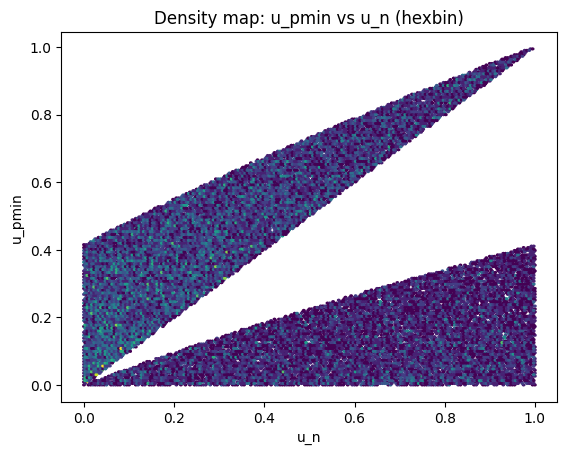

In [27]:
import matplotlib.pyplot as plt
X = df128["u_n"].to_numpy()
Y = df128["u_pmin"].to_numpy()

plt.figure()
plt.hexbin(X, Y, gridsize=200, mincnt=1)  # pas de couleur fixée explicitement
plt.xlabel("u_n")
plt.ylabel("u_pmin")
plt.title("Density map: u_pmin vs u_n (hexbin)")
plt.show()


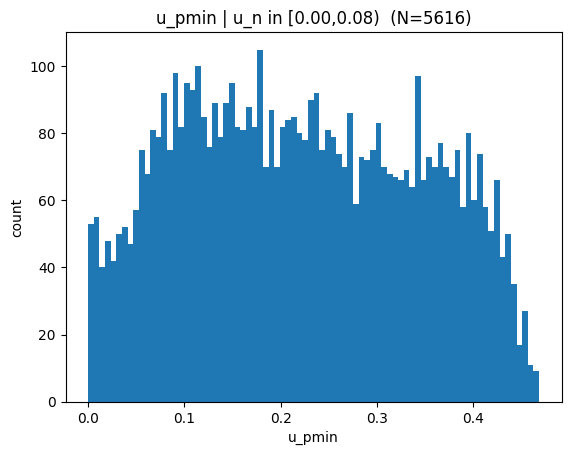

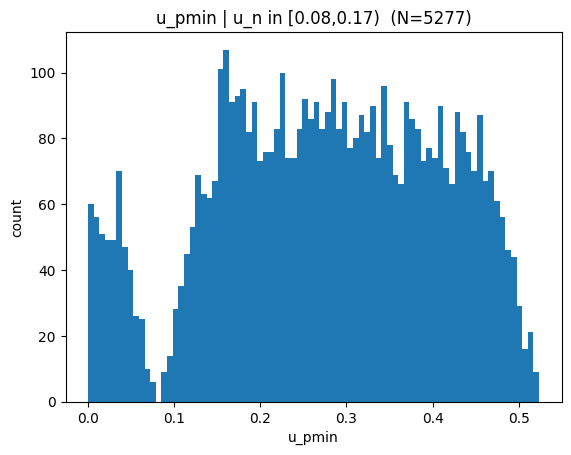

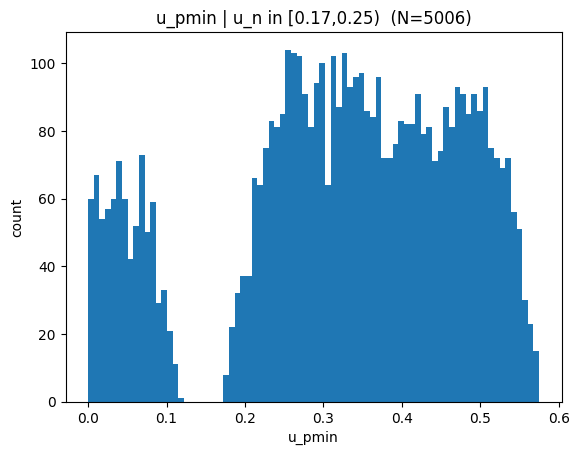

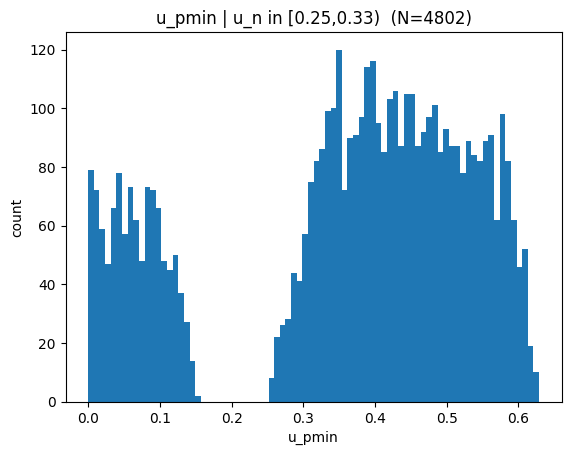

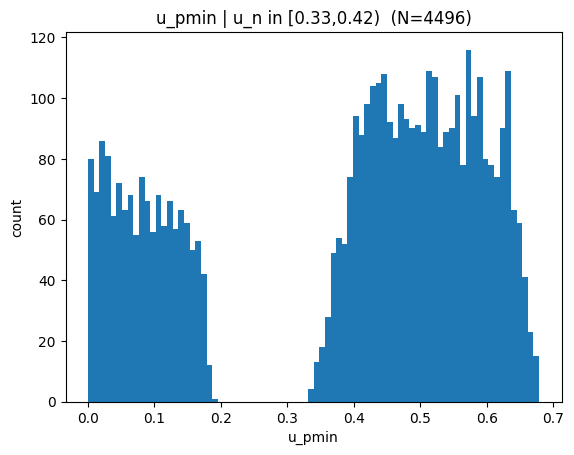

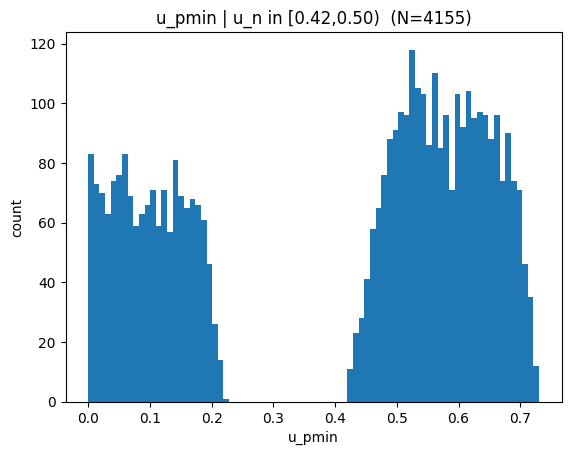

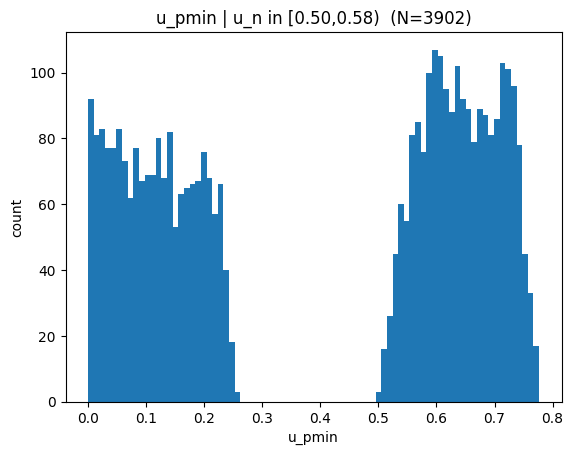

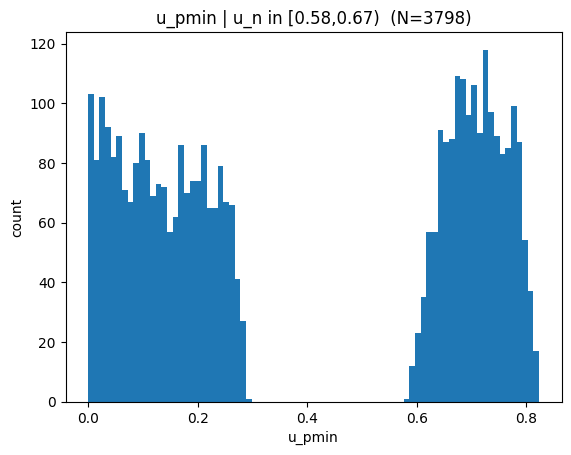

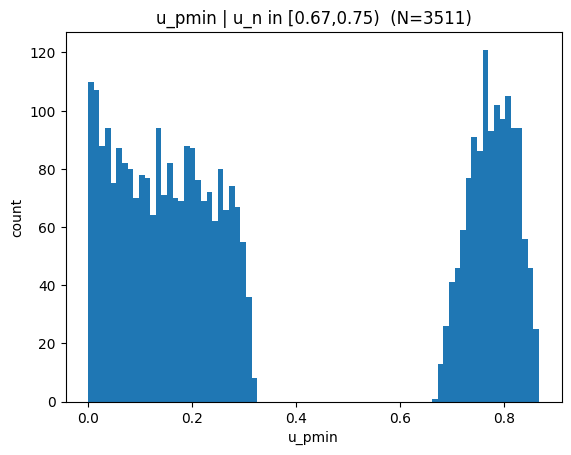

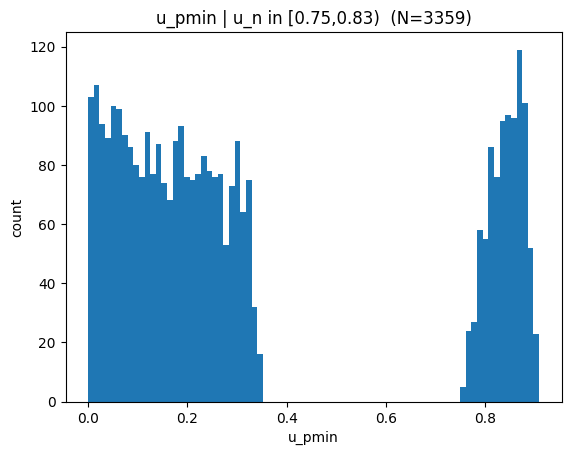

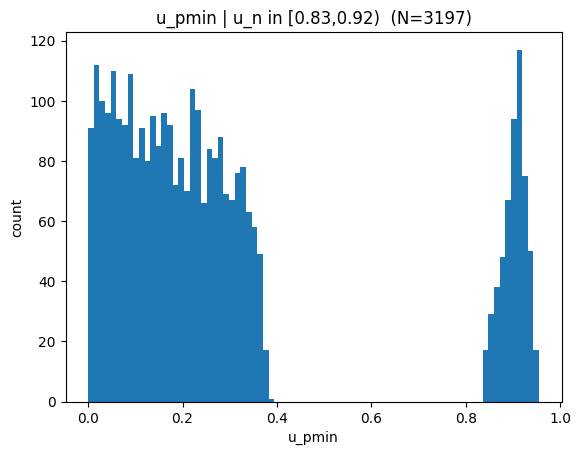

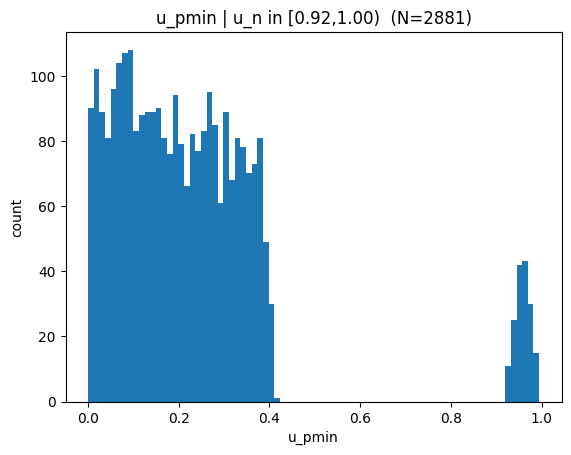

In [28]:
def slice_hists(df, bins_u=12, nbins_hist=80):
    X = df["u_n"].to_numpy()
    Y = df["u_pmin"].to_numpy()
    edges = np.linspace(0, 1, bins_u+1)

    for i in range(bins_u):
        a,b = edges[i], edges[i+1]
        m = (X>=a) & (X<b)
        y = Y[m]
        if len(y) < 300:
            continue
        plt.figure()
        plt.hist(y, bins=nbins_hist)
        plt.title(f"u_pmin | u_n in [{a:.2f},{b:.2f})  (N={len(y)})")
        plt.xlabel("u_pmin")
        plt.ylabel("count")
        plt.show()

slice_hists(df128, bins_u=12, nbins_hist=80)


In [31]:
def smooth1d(h, w=5):
    if w <= 1: 
        return h
    k = np.ones(w)/w
    return np.convolve(h, k, mode="same")

def valley_ratio(y, nbins=80, smooth_w=7):
    y = np.asarray(y)
    if len(y) < 400:
        return np.nan, None

    h, edges = np.histogram(y, bins=nbins, range=(0,1))
    hs = smooth1d(h.astype(float), w=smooth_w)

    # repère les maxima locaux
    peaks = []
    for i in range(1, len(hs)-1):
        if hs[i] > hs[i-1] and hs[i] >= hs[i+1]:
            peaks.append(i)

    if len(peaks) < 2:
        return 1.0, None  # unimodal-ish

    # garde les deux plus hauts pics
    peaks = sorted(peaks, key=lambda i: hs[i], reverse=True)[:2]
    p1, p2 = sorted(peaks)  # ordre gauche->droite

    if p2 <= p1+2:
        return 1.0, None

    valley = np.min(hs[p1:p2+1])
    peak_min = min(hs[p1], hs[p2])
    ratio = valley / max(peak_min, 1e-9)

    # seuil de séparation = position du minimum entre pics
    vpos = p1 + int(np.argmin(hs[p1:p2+1]))
    thr = 0.5*(edges[vpos] + edges[vpos+1])
    return float(ratio), float(thr)


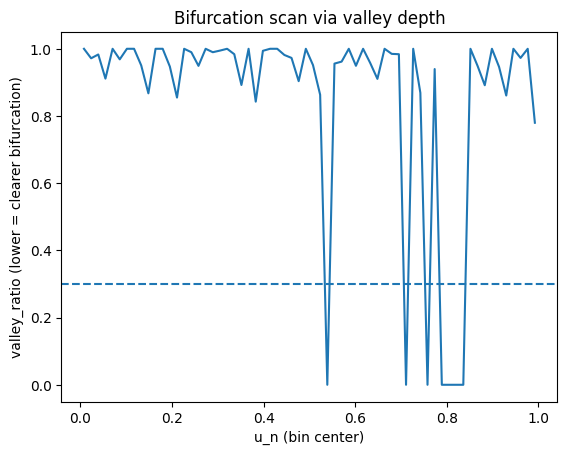

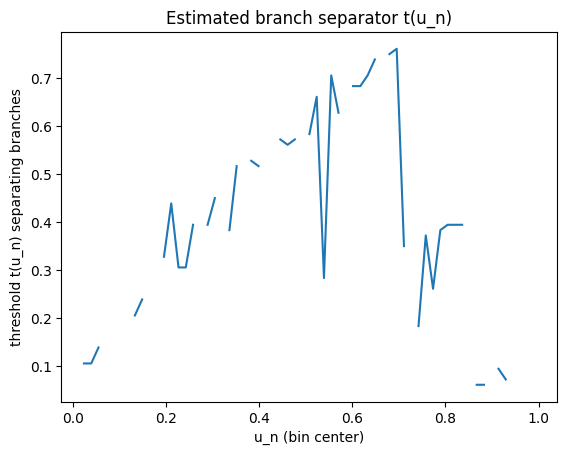

In [32]:
def scan_valley(df, bins_u=64, nbins_hist=80):
    X = df["u_n"].to_numpy()
    Y = df["u_pmin"].to_numpy()
    edges = np.linspace(0,1,bins_u+1)

    centers=[]; ratios=[]; thrs=[]; Ns=[]
    for i in range(bins_u):
        a,b = edges[i], edges[i+1]
        m = (X>=a) & (X<b)
        y = Y[m]
        if len(y) < 400:
            continue
        r, t = valley_ratio(y, nbins=nbins_hist, smooth_w=7)
        centers.append(0.5*(a+b))
        ratios.append(r)
        thrs.append(t if t is not None else np.nan)
        Ns.append(len(y))
    return np.array(centers), np.array(ratios), np.array(thrs), np.array(Ns)

centers, ratios, thrs, Ns = scan_valley(df128, bins_u=64, nbins_hist=90)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(centers, ratios)
plt.axhline(0.3, linestyle="--")  # ex: bimodal fort si <0.3
plt.xlabel("u_n (bin center)")
plt.ylabel("valley_ratio (lower = clearer bifurcation)")
plt.title("Bifurcation scan via valley depth")
plt.show()

plt.figure()
plt.plot(centers, thrs)
plt.xlabel("u_n (bin center)")
plt.ylabel("threshold t(u_n) separating branches")
plt.title("Estimated branch separator t(u_n)")
plt.show()


N= 771


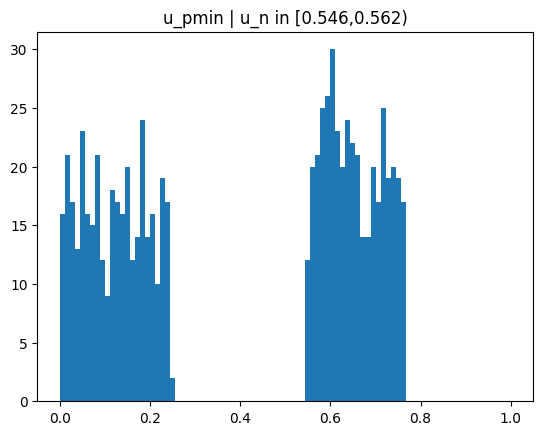

In [33]:
def show_bin(df, a, b, nbins=90):
    m = (df["u_n"]>=a) & (df["u_n"]<b)
    y = df.loc[m, "u_pmin"].to_numpy()
    print("N=", len(y))
    import matplotlib.pyplot as plt
    plt.figure()
    plt.hist(y, bins=nbins, range=(0,1))
    plt.title(f"u_pmin | u_n in [{a:.3f},{b:.3f})")
    plt.show()

# exemple autour du creux à u_n ~ 0.55 si bin_width=1/64≈0.0156
show_bin(df128, 0.546, 0.562)


In [34]:
def bifurcation_threshold(y, nbins=80, smooth_w=3):
    # histogramme
    hist, edges = np.histogram(y, bins=nbins, range=(0,1))
    centers = 0.5*(edges[:-1] + edges[1:])

    # lissage léger
    if smooth_w > 1:
        k = np.ones(smooth_w)/smooth_w
        hist_s = np.convolve(hist, k, mode="same")
    else:
        hist_s = hist

    # indices des pics
    peaks = np.argsort(hist_s)[-2:]
    p1, p2 = np.sort(peaks)

    # vallée entre les deux pics
    valley_idx = p1 + np.argmin(hist_s[p1:p2+1])
    thr = centers[valley_idx]

    valley_ratio = hist_s[valley_idx] / max(1, min(hist_s[p1], hist_s[p2]))
    return thr, valley_ratio


In [35]:
# bin u_n = [0.546, 0.562)
mask = (df128["u_n"] >= 0.546) & (df128["u_n"] < 0.562)
y = df128.loc[mask, "u_pmin"].to_numpy()

thr, vr = bifurcation_threshold(y, nbins=80, smooth_w=3)
print("N =", len(y))
print("thr =", thr)
print("valley_ratio =", vr)


N = 771
thr = 0.6062500000000001
valley_ratio = 1.0


In [36]:
import numpy as np

def thr_by_gap_window(y, nbins=120, smooth_w=5, win=(0.25, 0.55)):
    h, edges = np.histogram(y, bins=nbins, range=(0,1))
    centers = 0.5*(edges[:-1] + edges[1:])

    # lissage
    if smooth_w > 1:
        k = np.ones(smooth_w)/smooth_w
        hs = np.convolve(h.astype(float), k, mode="same")
    else:
        hs = h.astype(float)

    # cherche le min dans la fenêtre du "trou"
    m = (centers >= win[0]) & (centers <= win[1])
    if not np.any(m):
        return np.nan, np.nan

    idx = np.where(m)[0][np.argmin(hs[m])]
    thr = centers[idx]

    # ratio : hauteur vallée / hauteur max (pour lire facilement)
    valley_ratio = hs[idx] / max(hs.max(), 1e-9)
    return float(thr), float(valley_ratio)

mask = (df128["u_n"] >= 0.546) & (df128["u_n"] < 0.562)
y = df128.loc[mask, "u_pmin"].to_numpy()

thr, vr = thr_by_gap_window(y, nbins=120, smooth_w=5, win=(0.25, 0.55))
print("N =", len(y))
print("thr_gap =", thr)
print("valley_ratio_to_max =", vr)


N = 771
thr_gap = 0.27083333333333337
valley_ratio_to_max = 0.0


In [38]:
import numpy as np

def thr_center_of_gap(y, nbins=120, smooth_w=5, eps=0.5):
    h, edges = np.histogram(y, bins=nbins, range=(0,1))
    centers = 0.5*(edges[:-1] + edges[1:])

    # lissage
    if smooth_w > 1:
        k = np.ones(smooth_w)/smooth_w
        hs = np.convolve(h.astype(float), k, mode="same")
    else:
        hs = h.astype(float)

    # bins "vides" (ou quasi vides)
    empty = hs <= eps
    if not np.any(empty):
        return np.nan, np.nan, None

    # trouver le plus long segment contigu de "empty"
    best_len = 0
    best_i = None
    i = 0
    while i < len(empty):
        if not empty[i]:
            i += 1
            continue
        j = i
        while j < len(empty) and empty[j]:
            j += 1
        L = j - i
        if L > best_len:
            best_len = L
            best_i = (i, j-1)
        i = j

    i0, i1 = best_i
    thr = 0.5*(centers[i0] + centers[i1])
    gap = (centers[i0], centers[i1])
    return float(thr), float(best_len), gap

mask = (df128["u_n"] >= 0.546) & (df128["u_n"] < 0.562)
y = df128.loc[mask, "u_pmin"].to_numpy()

thr_gap_center, L, gap = thr_center_of_gap(y, nbins=120, smooth_w=5, eps=0.5)
print("thr_gap_center =", thr_gap_center)
print("gap interval =", gap, " length_bins =", L)


thr_gap_center = 0.4
gap interval = (np.float64(0.27083333333333337), np.float64(0.5291666666666667))  length_bins = 32.0


In [39]:
def thr_by_gap_then_peaks(y, nbins=120, smooth_w=5, eps=0.5):
    h, edges = np.histogram(y, bins=nbins, range=(0,1))
    centers = 0.5*(edges[:-1] + edges[1:])

    # lissage
    if smooth_w > 1:
        k = np.ones(smooth_w)/smooth_w
        hs = np.convolve(h.astype(float), k, mode="same")
    else:
        hs = h.astype(float)

    # 1) trouver le plus long gap
    empty = hs <= eps
    if not np.any(empty):
        return np.nan, None, None

    best_len = 0
    best = None
    i = 0
    while i < len(empty):
        if not empty[i]:
            i += 1
            continue
        j = i
        while j < len(empty) and empty[j]:
            j += 1
        if (j-i) > best_len:
            best_len = j-i
            best = (i, j-1)
        i = j

    i0, i1 = best
    g_lo, g_hi = float(centers[i0]), float(centers[i1])
    thr = 0.5*(g_lo + g_hi)

    # 2) pics contraints à gauche/droite du gap (juste pour diagnostic)
    left_mask  = centers < g_lo
    right_mask = centers > g_hi
    if np.any(left_mask):
        pL = int(np.argmax(hs[left_mask]))
        pL = np.where(left_mask)[0][pL]
    else:
        pL = None
    if np.any(right_mask):
        pR = int(np.argmax(hs[right_mask]))
        pR = np.where(right_mask)[0][pR]
    else:
        pR = None

    info = {
        "gap": (g_lo, g_hi),
        "gap_len_bins": int(best_len),
        "peak_left_at": float(centers[pL]) if pL is not None else np.nan,
        "peak_right_at": float(centers[pR]) if pR is not None else np.nan,
        "peak_left_h": float(hs[pL]) if pL is not None else np.nan,
        "peak_right_h": float(hs[pR]) if pR is not None else np.nan,
    }
    return thr, info, hs


In [40]:
mask = (df128["u_n"] >= 0.546) & (df128["u_n"] < 0.562)
y = df128.loc[mask, "u_pmin"].to_numpy()

thr, info, _ = thr_by_gap_then_peaks(y, nbins=120, smooth_w=5, eps=0.5)
print("thr =", thr)
print("info =", info)


thr = 0.4
info = {'gap': (0.27083333333333337, 0.5291666666666667), 'gap_len_bins': 32, 'peak_left_at': 0.0625, 'peak_right_at': 0.5958333333333333, 'peak_left_h': 14.600000000000001, 'peak_right_h': 19.200000000000003}


In [41]:
mask = (df128["u_n"] >= 0.546) & (df128["u_n"] < 0.562)
y = df128.loc[mask, "u_pmin"].to_numpy()

thr = 0.4
yL = y[y < thr]
yH = y[y >= thr]

print("support low/high:", len(yL), len(yH))

qL = np.quantile(yL, [0.05, 0.95])
qH = np.quantile(yH, [0.05, 0.95])
print("low Q5-95 :", qL)
print("high Q5-95:", qH)


support low/high: 362 409
low Q5-95 : [0.01219225 0.23413932]
high Q5-95: [0.56295173 0.75193521]
